<a href="https://colab.research.google.com/github/OmdenaAI/milan-chapter-agrifoods/blob/main/src/tasks/task_4%20Modeling/Yield_Estimation_Omdena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/OmdenaAI/milan-chapter-agrifoods.git

Cloning into 'milan-chapter-agrifoods'...
remote: Enumerating objects: 4118, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 4118 (delta 111), reused 102 (delta 91), pack-reused 3984
Receiving objects: 100% (4118/4118), 768.64 MiB | 16.94 MiB/s, done.
Resolving deltas: 100% (1104/1104), done.
Checking out files: 100% (154/154), done.


In [ ]:
!pip install xgboost --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 45 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

## Check Data

The following datasets are useful for yield prediction


1.   DCSP_COLTIVAZIONI - Crops - full dataset.csv
2.   FAOSTAT_Crop_pro_IT.csv
3.   FAOSTAT_FS_Ind_IT.csv
4.   italy_fertilizers.csv


However, some issues are there


*   I am unable to read 1. due to some error in the data. After inspecting the raw data I have concluded that it can be used in a time-series forecasting model
*   FAOSTAT_Crop_pro_IT.csv contains yield but no data on features
*   However, FAOSTAT_FS_Ind_IT can be used for features instead
*   italy_fertilizers.csv contains data regarding fertilizer quantity which can be used as a feature


In [ ]:
data_dir = Path('/content/milan-chapter-agrifoods/src/data')

In [ ]:
# crops_ds = pd.read_csv(str(data_dir / 'DCSP_COLTIVAZIONI - Crops - full dataset.csv'))
crop_pro_it = pd.read_csv(data_dir / 'FAOSTAT_Crop_pro_IT.csv')
fs_ind_it = pd.read_csv(data_dir / 'FAOSTAT_FS_Ind_IT.csv')
italy_fertilizers = pd.read_csv(data_dir / 'italy_fertilizers.csv')

In [ ]:
crop_pro_it.head()

In [ ]:
crop_pro_it = crop_pro_it.dropna(axis=0, subset=['Value'])

In [ ]:
crop_pro_it.head()

In [ ]:
fs_ind_it.head()

In [ ]:
fs_ind_it['Item'].unique()

In [ ]:
italy_fertilizers.head()

## Crop Yield Monitoring

In [ ]:
data_zip = '/content/milan-chapter-agrifoods/src/tasks/task_4 Modeling/crops_climate_fertilizers.zip'
!unzip "$data_zip"

Archive:  /content/milan-chapter-agrifoods/src/tasks/task_4 Modeling/crops_climate_fertilizers.zip
   creating: crops_climate_fertilizers/
  inflating: crops_climate_fertilizers/fertilizer2006-2021.csv  
  inflating: crops_climate_fertilizers/industrial_crop_climate2006-2021.csv  
  inflating: crops_climate_fertilizers/cereal_crop_climate2006-2021.csv  
  inflating: crops_climate_fertilizers/fruit_climate2006-2021.csv  
  inflating: crops_climate_fertilizers/fresh-veg_climate2006-2021.csv  
  inflating: crops_climate_fertilizers/grapes-olives_climate2006-2021.csv  


### Read Data

In [ ]:
data_dir = Path("/content/crops_climate_fertilizers")
cereal = pd.read_csv(data_dir / 'cereal_crop_climate2006-2021.csv')
print("=== cereal === ")
print(cereal.columns)
fertilizer = pd.read_csv(data_dir / 'fertilizer2006-2021.csv')
print("=== fertilizer === ")
print(fertilizer.columns)
fresh_veg = pd.read_csv(data_dir / 'fresh-veg_climate2006-2021.csv')
print("=== fresh_veg === ")
print(fresh_veg.columns)
fruit = pd.read_csv(data_dir / 'fruit_climate2006-2021.csv')
print("=== fruit === ")
print(fruit.columns)
grapes_olives = pd.read_csv(data_dir / 'grapes-olives_climate2006-2021.csv')
print("=== grapes_olives === ")
print(grapes_olives.columns)
industrial = pd.read_csv(data_dir / 'industrial_crop_climate2006-2021.csv')
print("=== industrial === ")
print(industrial.columns)

=== cereal === 
Index(['City', 'Type_crop', 'Year', 'Production_tonnes', 'PS', 'TS', 'QV2M',
       'RH2M', 'WS2M', 'GWETTOP', 'T2M_MAX', 'T2M_MIN', 'GWETPROF', 'GWETROOT',
       'CLOUD_AMT', 'T2M_RANGE', 'PRECTOTCORR', 'Fertilizers_tonnes', 'lat',
       'lon'],
      dtype='object')
=== fertilizer === 
Index(['City', 'Type_fertilizer', 'Year', 'Fertilizers_tonnes'], dtype='object')
=== fresh_veg === 
Index(['City', 'Type_crop', 'Year', 'Production_tonnes', 'PS', 'TS', 'QV2M',
       'RH2M', 'WS2M', 'GWETTOP', 'T2M_MAX', 'T2M_MIN', 'GWETPROF', 'GWETROOT',
       'CLOUD_AMT', 'T2M_RANGE', 'PRECTOTCORR', 'Fertilizers_tonnes', 'lat',
       'lon'],
      dtype='object')
=== fruit === 
Index(['City', 'Type_crop', 'Year', 'Production_tonnes', 'PS', 'TS', 'QV2M',
       'RH2M', 'WS2M', 'GWETTOP', 'T2M_MAX', 'T2M_MIN', 'GWETPROF', 'GWETROOT',
       'CLOUD_AMT', 'T2M_RANGE', 'PRECTOTCORR', 'Fertilizers_tonnes', 'lat',
       'lon'],
      dtype='object')
=== grapes_olives === 
Index(['City'

In [ ]:
cereal.head()

,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,122.7,42.1833,14.5333
1,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,1124.5,42.1833,14.5333
2,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,16166.9,42.1833,14.5333
3,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,13448.7,42.1833,14.5333
4,Torino,common wheat,2006,119700.0,93.51,10.72,6.16,64.9,1.33,0.62,24.23,1.0,0.61,0.61,58.07,23.23,1.79,934.7,42.1833,14.5333


In [ ]:
fertilizer.head()

,City,Type_fertilizer,Year,Fertilizers_tonnes
0,Torino,calcium cyanamide,2006,122.7
1,Torino,calcium cyanamide,2007,181.2
2,Torino,calcium cyanamide,2008,522.4
3,Torino,calcium cyanamide,2009,205.1
4,Torino,calcium cyanamide,2010,5.4


In [ ]:
for col in fertilizer:
    print(col)
    print(fertilizer[col].unique())
    print("======================")

City
['Torino' 'Vercelli' 'Biella' 'Verbano-Cusio-Ossola' 'Novara' 'Cuneo'
 'Asti' 'Alessandria' "Valle d'Aosta / Vallée d'Aoste" 'Imperia' 'Savona'
 'Genova' 'La Spezia' 'Varese' 'Como' 'Lecco' 'Sondrio' 'Milano' 'Bergamo'
 'Brescia' 'Pavia' 'Lodi' 'Cremona' 'Mantova'
 'Trentino Alto Adige / Südtirol' 'Provincia Autonoma Bolzano / Bozen'
 'Provincia Autonoma Trento' 'Verona' 'Vicenza' 'Belluno' 'Treviso'
 'Venezia' 'Padova' 'Rovigo' 'Pordenone' 'Udine' 'Gorizia' 'Trieste'
 'Piacenza' 'Parma' "Reggio nell'Emilia" 'Modena' 'Bologna' 'Ferrara'
 'Ravenna' 'Forlì-Cesena' 'Rimini' 'Massa-Carrara' 'Lucca' 'Pistoia'
 'Firenze' 'Prato' 'Livorno' 'Pisa' 'Arezzo' 'Siena' 'Grosseto' 'Perugia'
 'Terni' 'Pesaro e Urbino' 'Ancona' 'Macerata' 'Ascoli Piceno' 'Viterbo'
 'Rieti' 'Roma' 'Latina' 'Frosinone' "L'Aquila" 'Teramo' 'Pescara'
 'Chieti' 'Isernia' 'Campobasso' 'Caserta' 'Messina' 'Oristano'
 'Carbonia-Iglesias' 'Reggio di Calabria' 'Caltanissetta'
 'Barletta-Andria-Trani' 'Benevento' 'Sassari' 

In [ ]:
print(fresh_veg.shape)
fresh_veg.head()

(526897, 20)


,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Cuneo,chicory and radicchio in greenhouses,2006,30.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,285.9,44.3833,7.55
1,Cuneo,chicory and radicchio in greenhouses,2006,30.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,934.6,44.3833,7.55
2,Cuneo,chicory and radicchio in greenhouses,2006,30.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,12478.1,44.3833,7.55
3,Cuneo,chicory and radicchio in greenhouses,2006,30.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,6268.9,44.3833,7.55
4,Cuneo,chicory and radicchio in greenhouses,2006,30.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,1740.4,44.3833,7.55


In [ ]:
print(fruit.shape)
fruit.head()

(203150, 20)


,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Perugia,nectarine,2006,292.5,96.64,13.1,7.28,74.68,2.25,0.62,25.83,2.38,0.61,0.63,53.06,23.46,1.82,74.4,43.1121,12.3888
1,Perugia,nectarine,2006,292.5,96.64,13.1,7.28,74.68,2.25,0.62,25.83,2.38,0.61,0.63,53.06,23.46,1.82,1988.3,43.1121,12.3888
2,Perugia,nectarine,2006,292.5,96.64,13.1,7.28,74.68,2.25,0.62,25.83,2.38,0.61,0.63,53.06,23.46,1.82,21619.3,43.1121,12.3888
3,Perugia,nectarine,2006,292.5,96.64,13.1,7.28,74.68,2.25,0.62,25.83,2.38,0.61,0.63,53.06,23.46,1.82,17588.4,43.1121,12.3888
4,Perugia,nectarine,2006,292.5,96.64,13.1,7.28,74.68,2.25,0.62,25.83,2.38,0.61,0.63,53.06,23.46,1.82,816.6,43.1121,12.3888


In [ ]:
print(grapes_olives.shape)
grapes_olives.head()

(52024, 20)


,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Lucca,wine,2006,5431.0,95.5,12.15,7.24,76.62,1.5,0.6,23.13,2.5,0.57,0.6,49.3,20.63,1.72,83.1,43.85,10.5167
1,Lucca,wine,2006,5431.0,95.5,12.15,7.24,76.62,1.5,0.6,23.13,2.5,0.57,0.6,49.3,20.63,1.72,117.3,43.85,10.5167
2,Lucca,wine,2006,5431.0,95.5,12.15,7.24,76.62,1.5,0.6,23.13,2.5,0.57,0.6,49.3,20.63,1.72,2414.6,43.85,10.5167
3,Lucca,wine,2006,5431.0,95.5,12.15,7.24,76.62,1.5,0.6,23.13,2.5,0.57,0.6,49.3,20.63,1.72,682.2,43.85,10.5167
4,Lucca,wine,2006,5431.0,95.5,12.15,7.24,76.62,1.5,0.6,23.13,2.5,0.57,0.6,49.3,20.63,1.72,92.7,43.85,10.5167


In [ ]:
print(industrial.shape)
industrial.head()

(65820, 20)


,City,Type_crop,Year,Production_tonnes,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
0,Cuneo,parsley in greenhouses,2006,75.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,285.9,44.3833,7.55
1,Cuneo,parsley in greenhouses,2006,75.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,934.6,44.3833,7.55
2,Cuneo,parsley in greenhouses,2006,75.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,12478.1,44.3833,7.55
3,Cuneo,parsley in greenhouses,2006,75.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,6268.9,44.3833,7.55
4,Cuneo,parsley in greenhouses,2006,75.0,90.28,9.04,5.88,68.47,1.4,0.61,22.61,-0.84,0.58,0.6,55.45,23.45,1.86,1740.4,44.3833,7.55


### Modeling

In [ ]:
data = [cereal, fresh_veg, fruit, grapes_olives, industrial]
yield_df = pd.concat(data, axis=0)
yield_df.shape

(1056390, 20)

In [ ]:
yield_df = pd.read_csv('/content/cereal_final_dataset_2006-2021.csv')
yield_df = yield_df.rename({"production_tonnes": "Production_tonnes"}, axis=1)
yield_df.head()

,City,Type_crop,Year,Production_tonnes,total_area_ha,PS,TS,QV2M,RH2M,WS2M,...,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Type_fertilizer,Fertilizers_tonnes,lat,lon
0,Agrigento,barley,2006,897.0,345.0,96.87,16.7,8.33,71.95,2.61,...,6.77,0.61,0.62,39.63,21.74,1.58,calcium cyanamide,0.0,37.3111,13.5765
1,Agrigento,barley,2006,897.0,345.0,96.87,16.7,8.33,71.95,2.61,...,6.77,0.61,0.62,39.63,21.74,1.58,nitrogen-potassium,27.7,37.3111,13.5765
2,Agrigento,barley,2006,897.0,345.0,96.87,16.7,8.33,71.95,2.61,...,6.77,0.61,0.62,39.63,21.74,1.58,peaty-amend,174.5,37.3111,13.5765
3,Agrigento,barley,2006,897.0,345.0,96.87,16.7,8.33,71.95,2.61,...,6.77,0.61,0.62,39.63,21.74,1.58,organic-nitrogen,760.5,37.3111,13.5765
4,Agrigento,barley,2006,897.0,345.0,96.87,16.7,8.33,71.95,2.61,...,6.77,0.61,0.62,39.63,21.74,1.58,organic,1343.7,37.3111,13.5765


In [ ]:
yield_df.columns

Index(['City', 'Type_crop', 'Year', 'Production_tonnes', 'total_area_ha', 'PS',
       'TS', 'QV2M', 'RH2M', 'WS2M', 'GWETTOP', 'T2M_MAX', 'T2M_MIN',
       'GWETPROF', 'GWETROOT', 'CLOUD_AMT', 'T2M_RANGE', 'PRECTOTCORR',
       'Type_fertilizer', 'Fertilizers_tonnes', 'lat', 'lon'],
      dtype='object')

#### Model for Cereal

In [ ]:
# yield_df = data[0]
# yield_df.head()

In [ ]:
yield_df.describe()

,Year,Production_tonnes,total_area_ha,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon
count,206851.000000,2.068510e+05,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000,206851.000000
mean,2013.878632,1.856273e+04,2853.384098,94.209545,13.998612,7.591093,70.097731,2.113781,0.613320,24.180655,4.943192,0.606564,0.614794,50.207070,19.237350,2.096136,1879.881017,42.288778,12.038671
std,4.644129,6.421528e+04,10170.667240,18.695986,4.037118,1.728335,14.019197,0.914664,0.145626,5.313291,3.826400,0.139241,0.140295,11.872986,5.021068,0.757559,4502.608715,5.510410,2.922570
min,2006.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,1.035000e+02,33.000000,95.860000,12.590000,7.180000,70.610000,1.490000,0.570000,23.530000,2.630000,0.570000,0.580000,46.630000,17.750000,1.650000,37.000000,40.915300,10.033300
50%,2014.000000,8.920000e+02,181.000000,98.530000,14.680000,7.770000,72.570000,2.010000,0.630000,25.340000,4.560000,0.620000,0.640000,52.240000,20.710000,2.090000,297.000000,43.463100,12.199400
75%,2018.000000,7.440000e+03,1469.000000,99.610000,16.650000,8.440000,74.610000,2.640000,0.700000,26.670000,7.500000,0.680000,0.690000,56.830000,22.310000,2.500000,1474.700000,45.133300,14.167400
max,2021.000000,1.016400e+06,242000.000000,101.700000,20.320000,10.600000,84.970000,4.700000,0.890000,30.900000,14.270000,0.850000,0.840000,74.910000,28.000000,4.990000,98671.600000,46.500000,18.169100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


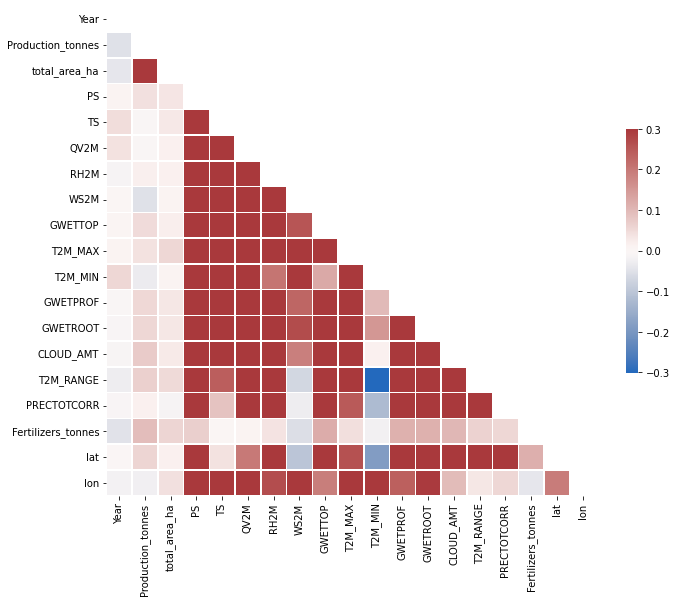

In [ ]:
correlation_data = yield_df.select_dtypes(include=[np.number]).corr()

mask = np.zeros_like(correlation_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.palette="vlag"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_data, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
string_cols = ['City', 'Type_crop', 'Type_fertilizer']
target = 'Production_tonnes'

In [ ]:
yield_df_onehot = pd.get_dummies(yield_df, columns=string_cols, prefix = string_cols)	
features = yield_df_onehot.loc[:, yield_df_onehot.columns != target]
label = yield_df[target]
features.head()

,Year,total_area_ha,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,...,Type_fertilizer_0,Type_fertilizer_ammonium sulphate,Type_fertilizer_calcium cyanamide,Type_fertilizer_nitrogen-phosphorous,Type_fertilizer_nitrogen-potassium,Type_fertilizer_organic,Type_fertilizer_organic-nitrogen,Type_fertilizer_peaty-amend,Type_fertilizer_phosphorus-potassium,Type_fertilizer_urea
0,2006,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,...,0,0,1,0,0,0,0,0,0,0
1,2006,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,...,0,0,0,0,1,0,0,0,0,0
2,2006,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,...,0,0,0,0,0,0,0,1,0,0
3,2006,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,...,0,0,0,0,0,0,1,0,0,0
4,2006,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
features = features.drop(['Year'], axis=1)

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206851 entries, 0 to 206850
Columns: 169 entries, total_area_ha to Type_fertilizer_urea
dtypes: float64(17), uint8(152)
memory usage: 56.8 MB


In [ ]:
features.head()

,total_area_ha,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,...,Type_fertilizer_0,Type_fertilizer_ammonium sulphate,Type_fertilizer_calcium cyanamide,Type_fertilizer_nitrogen-phosphorous,Type_fertilizer_nitrogen-potassium,Type_fertilizer_organic,Type_fertilizer_organic-nitrogen,Type_fertilizer_peaty-amend,Type_fertilizer_phosphorus-potassium,Type_fertilizer_urea
0,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,0.61,...,0,0,1,0,0,0,0,0,0,0
1,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,0.61,...,0,0,0,0,1,0,0,0,0,0
2,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,0.61,...,0,0,0,0,0,0,0,1,0,0
3,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,0.61,...,0,0,0,0,0,0,1,0,0,0
4,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,0.61,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
scaler = MinMaxScaler()
features = scaler.fit_transform(features) 

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.3, random_state=42)

In [ ]:
def compare_models(model):
    model_name = model.__class__.__name__
    model.fit(train_data, train_labels)
    y_pred = model.predict(test_data)
    r2 = r2_score(test_labels,y_pred)
    mse = mean_squared_error(test_labels, y_pred)
    rmse = np.sqrt(mse)
    return [model_name, r2, rmse]

In [ ]:
# models = [
#     RandomForestRegressor(n_estimators=200, max_depth=8, random_state=0),
#     AdaBoostRegressor(n_estimators=200, random_state=0),
#     GradientBoostingRegressor(n_estimators=200, max_depth=8, random_state=0),
#     svm.SVR(),
#     DecisionTreeRegressor(),
#     xgb.XGBRegressor(random_state=0, tree_method='gpu_hist', n_estimators=200, max_depth=8, reg_lambda=0.5)
# ]

In [ ]:
# model = xgb.XGBRegressor(random_state=0, tree_method='gpu_hist', n_estimators=200, max_depth=8, reg_lambda=0.5)  
# scores = cross_validate(model, features, label, cv=10, scoring=['r2', 'neg_root_mean_squared_error'], return_train_score=True)
# pprint(scores)

In [ ]:
model = xgb.XGBRegressor(random_state=0, tree_method='gpu_hist', n_estimators=200, max_depth=8, reg_lambda=0.5)  
model_name, r2, rmse = compare_models(model)
print(model_name, r2, rmse)

XGBRegressor 0.9999529745534277 444.88988679890593


In [ ]:
yield_df_onehot = yield_df_onehot.drop(['Year'], axis=1)
yield_df_onehot.head()

,Production_tonnes,total_area_ha,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,...,Type_fertilizer_0,Type_fertilizer_ammonium sulphate,Type_fertilizer_calcium cyanamide,Type_fertilizer_nitrogen-phosphorous,Type_fertilizer_nitrogen-potassium,Type_fertilizer_organic,Type_fertilizer_organic-nitrogen,Type_fertilizer_peaty-amend,Type_fertilizer_phosphorus-potassium,Type_fertilizer_urea
0,897.0,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,...,0,0,1,0,0,0,0,0,0,0
1,897.0,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,...,0,0,0,0,1,0,0,0,0,0
2,897.0,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,...,0,0,0,0,0,0,0,1,0,0
3,897.0,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,...,0,0,0,0,0,0,1,0,0,0
4,897.0,345.0,96.87,16.7,8.33,71.95,2.61,0.58,28.51,6.77,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
#setting test data to columns from dataframe and excluding 'hg/ha_yield' values where ML model should be predicting 

test_df=pd.DataFrame(test_data,columns=yield_df_onehot.loc[:, yield_df_onehot.columns != target].columns) 
test_df.head()

,total_area_ha,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,...,Type_fertilizer_0,Type_fertilizer_ammonium sulphate,Type_fertilizer_calcium cyanamide,Type_fertilizer_nitrogen-phosphorous,Type_fertilizer_nitrogen-potassium,Type_fertilizer_organic,Type_fertilizer_organic-nitrogen,Type_fertilizer_peaty-amend,Type_fertilizer_phosphorus-potassium,Type_fertilizer_urea
0,0.019421,0.942183,0.695866,0.742453,0.889137,0.453191,0.707865,0.850485,0.590761,0.682353,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.000037,0.996460,0.721949,0.715094,0.849829,0.385106,0.662921,0.881553,0.659690,0.682353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.002066,0.972173,0.737205,0.768868,0.889255,0.612766,0.775281,0.771197,0.745218,0.788235,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.250264,0.913864,0.600394,0.700000,0.916794,0.423404,0.786517,0.777346,0.549982,0.811765,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.013347,0.972861,0.761811,0.727358,0.830646,0.614894,0.685393,0.801618,0.734031,0.729412,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
for name in string_cols:
    # using stack function to return a reshaped DataFrame by pivoting the columns of the current dataframe
    df=test_df[[col for col in test_df.columns if name in col]].stack()[
        test_df[[col for col in test_df.columns if name in col]].stack()>0]

    dflist=list(pd.DataFrame(df).index.get_level_values(1))
    dfs=[i.split("_")[1] for i in dflist]
    test_df.drop([col for col in test_df.columns if name in col],axis=1,inplace=True)
    test_df[name] = dfs
test_df.head()

,total_area_ha,PS,TS,QV2M,RH2M,WS2M,GWETTOP,T2M_MAX,T2M_MIN,GWETPROF,GWETROOT,CLOUD_AMT,T2M_RANGE,PRECTOTCORR,Fertilizers_tonnes,lat,lon,City,Type_crop,Type_fertilizer
0,0.019421,0.942183,0.695866,0.742453,0.889137,0.453191,0.707865,0.850485,0.590761,0.682353,0.702381,0.598318,0.833571,0.434870,0.000557,0.879899,0.814003,Avellino,crop,fertilizer
1,0.000037,0.996460,0.721949,0.715094,0.849829,0.385106,0.662921,0.881553,0.659690,0.682353,0.714286,0.776398,0.800000,0.402806,0.001044,0.971105,0.593926,Mantova,crop,fertilizer
2,0.002066,0.972173,0.737205,0.768868,0.889255,0.612766,0.775281,0.771197,0.745218,0.788235,0.821429,0.761581,0.593929,0.484970,0.033596,0.947514,0.691740,Rimini,crop,fertilizer
3,0.250264,0.913864,0.600394,0.700000,0.916794,0.423404,0.786517,0.777346,0.549982,0.811765,0.845238,0.771326,0.793571,0.587174,0.000143,0.873834,0.869608,Potenza,crop,fertilizer
4,0.013347,0.972861,0.761811,0.727358,0.830646,0.614894,0.685393,0.801618,0.734031,0.729412,0.761905,0.664264,0.638214,0.368737,0.025712,0.947514,0.691740,Rimini,crop,fertilizer


In [ ]:
# i = ...
# clf= model_train[i][0]
# clf = model
# model=clf.fit(train_data,train_labels)

test_df["yield_predicted"]= model.predict(test_data)
test_df["yield_actual"]=pd.DataFrame(test_labels)[target].tolist()
test_group=test_df.groupby("Type_crop")
test_group.apply(lambda x: r2_score(x.yield_actual,x.yield_predicted))

Type_crop
crop    0.999953
dtype: float64

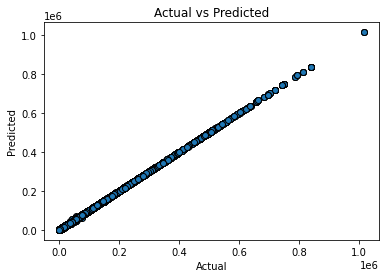

In [ ]:
# So let's run the model actual values against the predicted ones 

fig, ax = plt.subplots() 

ax.scatter(test_df["yield_actual"], test_df["yield_predicted"],edgecolors=(0, 0, 0))

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()

In [ ]:
def adjusted_r_squared(y,yhat,x):
    score=1- (((1-(r2_score(y,yhat)))*(len(y)-1))/(len(y)-x.shape[1]-2))
    return score

test_group.apply(lambda x: adjusted_r_squared(x.yield_actual,x.yield_predicted,x))

Type_crop
crop    0.999953
dtype: float64

In [ ]:
varimp= {'imp':model.feature_importances_,'names':yield_df_onehot.columns[yield_df_onehot.columns!=target]}

In [ ]:
df[:10]

0  Type_fertilizer_nitrogen-potassium      1.0
1  Type_fertilizer_peaty-amend             1.0
2  Type_fertilizer_organic                 1.0
3  Type_fertilizer_nitrogen-potassium      1.0
4  Type_fertilizer_organic-nitrogen        1.0
5  Type_fertilizer_phosphorus-potassium    1.0
6  Type_fertilizer_peaty-amend             1.0
7  Type_fertilizer_phosphorus-potassium    1.0
8  Type_fertilizer_calcium cyanamide       1.0
9  Type_fertilizer_peaty-amend             1.0
dtype: float64

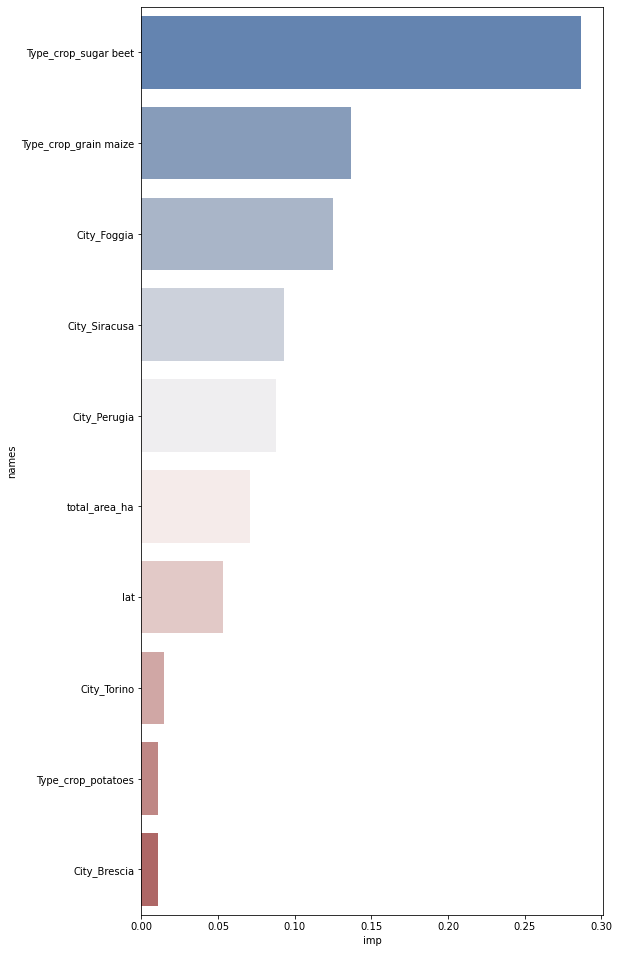

In [ ]:
a4_dims = (8.27,16.7)

fig, ax = plt.subplots(figsize=a4_dims)
df=pd.DataFrame.from_dict(varimp)
df.sort_values(ascending=False,by=["imp"],inplace=True)
df=df.dropna()
sns.barplot(x="imp",y="names",palette="vlag",data=df.iloc[:10],orient="h",ax=ax);

In [ ]:
# save model
import pickle

with open("xgboost.pkl", "wb") as f:
    pickle.dump(model, f)